In [1]:
# import libraries
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Preprocess the images
This involves resizing the images to a consistent size, converting them to grayscale, reducing noise and normalizing the pixel values

## Load images from google drive folder
First up, we mount the google drive and define the constants required to load the images (batch size and image size).


In [2]:
# Define constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Directories 
# One folder per class -> populate each folder with images of a posture
reading_dir = "./reading"
computer_dir = "./computer"
writing_dir = "./writing"

Mounted at /content/drive


We create a function to read in 1 image and apply preprocessing techniques on it:


*   Grayscale
*   Standardise image size
* Noise Reduction
* Normalise pixel values -> improves image contrast and visibility



In [3]:
def preprocess_img(img_path):
  # 1. Load images in grayscale
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  # 2. Standardise image size
  img = cv2.resize(img, IMG_SIZE)
  # 3. Reduce noise with Gaussian Blur
  img = cv2.GaussianBlur(img, (5, 5), 0)
  # 4. Normalise pixel values
  # Comment out so it can be used in canny edge detection
  # img = img.astype("float32") / 255.0
  return img

Next, we create a function to load the preprocessed images in batches. This is a more efficient way to load images and prevents this process of loading images from taking too much RAM

In [4]:
# Label 1 for images with weapon, 0 for those without
def image_generator(directory, label, batch_size=BATCH_SIZE):
  image_files = os.listdir(directory)
  total_images = len(image_files)
  indices = np.arange(total_images)
  for start in range(0, total_images, batch_size):
    end = min(start + batch_size, total_images)
    batch_indices = indices[start:end]
    batch_images = []
    for i in batch_indices:
      print(image_files[i])
      img = preprocess_img(os.path.join(directory, image_files[i]))
      batch_images.append(img)

    batch_labels = [label] * len(batch_images)
    yield np.array(batch_images), np.array(batch_labels), total_images

# Sanity check image_generator function (test 1 iteration to see if it works)
next(image_generator(train_weapon_dir, 1))

0204812_20220901_threat_1237_360.png
0204722_threat_1235_80.png
0204722_threat_1236_100.png
0204722_threat_1236_160.png
0204722_threat_1234_160.png
0204722_threat_1235_200.png
0204722_threat_1237_140.png
0204722_threat_1234_80.png
0204722_threat_1235_140.png
0204722_threat_1234_100.png
0204812_20220901_threat_1237_160.png
0204722_threat_1235_160.png
0204722_threat_1235_120.png
0205705_20220904_0002_480.png
0204722_threat_1234_120.png
0204722_threat_1235_240.png
0204722_carrying_1246_120.png
0204722_threat_1235_100.png
0204812_20220901_carrying_1210_200.png
0204722_threat_1238_240.png
0205250_20220828_threat_4859_140.png
0204812_20220901_carrying_1210_80.png
0201689_20220904_threat_8130_180.png
0201689_20220904_threat_6813_280.png
0201689_20220904_threat_8130_140.png
0201689_20220904_threat_8130_200.png
0201689_20220904_threat_8130_120.png
0201866_20220828_carrying_2000_80.png
0201689_20220904_threat_8130_100.png
0201866_20220828_carrying_2000_140.png
0201866_20220828_carrying_2000_120.

(array([[[212, 212, 211, ...,   0,   0,   0],
         [212, 212, 210, ...,   0,   0,   0],
         [212, 211, 209, ...,   0,   0,   0],
         ...,
         [ 17,  12,   5, ...,   0,   0,   0],
         [ 24,  19,  11, ...,   0,   0,   0],
         [ 26,  22,  14, ...,   0,   0,   0]],
 
        [[151, 151, 150, ..., 192, 192, 191],
         [151, 151, 151, ..., 192, 192, 191],
         [152, 152, 151, ..., 192, 191, 191],
         ...,
         [ 83,  83,  80, ...,  76,  81,  86],
         [ 76,  75,  75, ...,  77,  94, 105],
         [ 71,  72,  73, ...,  77, 101, 114]],
 
        [[ 53,  54,  57, ...,  14,  12,  11],
         [ 54,  55,  56, ...,  13,  11,  10],
         [ 55,  54,  54, ...,  11,  10,   9],
         ...,
         [108, 108, 110, ...,  60,  22,  10],
         [105, 106, 109, ...,  63,  23,  10],
         [104, 105, 109, ...,  66,  24,  11]],
 
        ...,
 
        [[ 19,  19,  18, ...,  33,  31,  30],
         [ 19,  19,  19, ...,  33,  31,  31],
         [ 19,

# 2. Extract features from the images
We can try exploring a combination of OpenCV Selective search segmentation and edge detection/texture analysis to extract features of weapons from the images.

I started a simple trial run using Canny for edge detection and LBP for texture detection to extract features from these images

The features and labels are then organised into variables x and y before being fed to the model.

Standard Scalar is then used to ensure all features have the same scale.

## Beware this cell takes a while to run
Took 7 min 58 s for me

In [5]:
def extract_edge_and_texture_features(img):
    # Edge detection using Canny
    edges = cv2.Canny(img, 100, 200).flatten()

    # Texture using LBP with scikit-image
    P = 8  # number of circularly symmetric neighbor pixels to use
    R = 1  # radius of circle
    lbp_img = local_binary_pattern(img, P, R, method="uniform")
    lbp_hist, _ = np.histogram(lbp_img.ravel(), bins=P+2, range=(0, P+2))
    lbp_hist_normalized = lbp_hist / np.sum(lbp_hist)  # Normalize the histogram

    return np.hstack((edges, lbp_hist_normalized))

def extract_features(directory, label):
    samples, labels = [], []
    for batch_imgs, batch_labels, total_images in image_generator(directory, label):
        batch_features = [extract_edge_and_texture_features(img) for img in batch_imgs]
        samples.extend(batch_features)
        labels.extend(batch_labels)
    return np.array(samples), np.array(labels)

# Extract features
# Label 1 for images with weapon, 0 for those without
weapon_features, weapon_labels = extract_features(train_weapon_dir, 1)
no_weapon_features, no_weapon_labels = extract_features(train_norm_dir, 0)

X = np.concatenate([weapon_features, no_weapon_features])
y = np.concatenate([weapon_labels, no_weapon_labels])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

0204812_20220901_threat_1237_360.png
0204722_threat_1235_80.png
0204722_threat_1236_100.png
0204722_threat_1236_160.png
0204722_threat_1234_160.png
0204722_threat_1235_200.png
0204722_threat_1237_140.png
0204722_threat_1234_80.png
0204722_threat_1235_140.png
0204722_threat_1234_100.png
0204812_20220901_threat_1237_160.png
0204722_threat_1235_160.png
0204722_threat_1235_120.png
0205705_20220904_0002_480.png
0204722_threat_1234_120.png
0204722_threat_1235_240.png
0204722_carrying_1246_120.png
0204722_threat_1235_100.png
0204812_20220901_carrying_1210_200.png
0204722_threat_1238_240.png
0205250_20220828_threat_4859_140.png
0204812_20220901_carrying_1210_80.png
0201689_20220904_threat_8130_180.png
0201689_20220904_threat_6813_280.png
0201689_20220904_threat_8130_140.png
0201689_20220904_threat_8130_200.png
0201689_20220904_threat_8130_120.png
0201866_20220828_carrying_2000_80.png
0201689_20220904_threat_8130_100.png
0201866_20220828_carrying_2000_140.png
0201866_20220828_carrying_2000_120.

# 3. Train Baseline classifier (SVM)
We can use SVM here because it is effective when there is a clear margin of separation between the classes. Over here, we feed the extracted features from the images to the SVM classifier along with the corresponding labels (i.e. whether the image contains a weapon or not).

# Hyperparameter tuning
There are a couple of hyperparameters the SVM classifier can take in and we don't know which ones will give the best results. Hyperparameter tuning goes through a list of different values per parameter and tries to find the optimal parameters that will give the best result. In our case, because we only have 2 classes, the linear kernel of the SVM would work best which means the only hyperparameter we can really adjust is 'C'. C controls the trade-off between model complexity and generalization performance. A higher 'c' value will lead to a more complex model but also increases risk of overfitting. A lower 'c' value will lead to a simpler model that may not be able to learn underlying relationships in data.

**Warning: Running the hyperparameter tuned SVM takes about 30mins!**
Uncomment clf= SVC(kernel='linear') and comment clf = grid if you want to skip hyperparameter tuning. Results don't differ much.

In [10]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'kernel': ['linear']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 5)

In [11]:
# Train SVM
# clf = SVC(kernel='linear')
clf = grid
clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.862 total time= 1.1min
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.859 total time= 1.2min
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.871 total time= 1.1min
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.867 total time= 1.1min
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.865 total time= 1.1min
[CV 1/5] END ................C=1, kernel=linear;, score=0.862 total time= 1.1min
[CV 2/5] END ................C=1, kernel=linear;, score=0.859 total time= 1.2min
[CV 3/5] END ................C=1, kernel=linear;, score=0.871 total time= 1.1min
[CV 4/5] END ................C=1, kernel=linear;, score=0.867 total time= 1.1min
[CV 5/5] END ................C=1, kernel=linear;, score=0.865 total time= 1.1min
[CV 1/5] END ...............C=10, kernel=linear;, score=0.862 total time= 1.1min
[CV 2/5] END ...............C=10, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
             verbose=3)

# 4. Evaluate Baseline classifier (SVM)
Throw test set data into our trained SVM model and print out evaluation metrics (classification accuracy and confusion matrix are preferred by prof). We also use precision and recall to see how well our data has been classified.

- Precision: How many retrieved items are relevant? (i.e. Out of all the data classified as positive, how many of them are actually positive?)
- Recall: How many relevant items are retrieved? (i.e. Out of all the data that are labelled as positive, how many of them end up being classified as positive?)

**Todo: Train it with dataset from the test folder (need to load the images in from there)**

Classification Accuracy: 84.04%
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       388
           1       0.85      0.79      0.82       320

    accuracy                           0.84       708
   macro avg       0.84      0.84      0.84       708
weighted avg       0.84      0.84      0.84       708



Text(0.5, 1.0, 'Confusion Matrix')

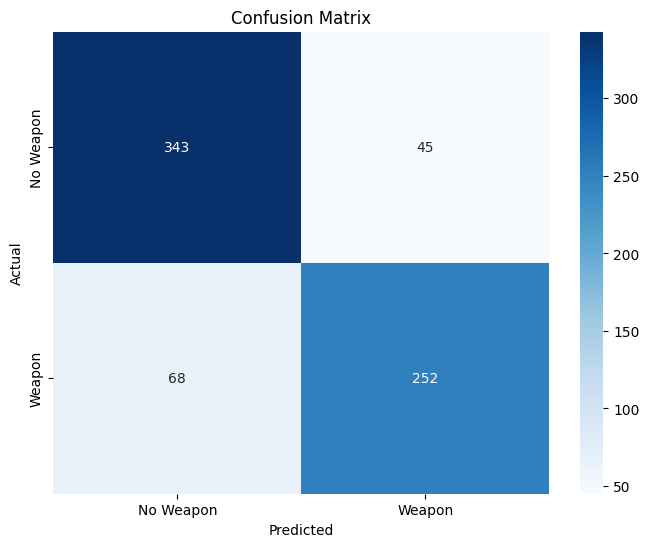

In [12]:
# Evaluate
# 1. Predict the classes on the test set
y_pred = clf.predict(X_test)

# 2. Calculate the classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

# 3. Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# 4. Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Weapon", "Weapon"],
            yticklabels=["No Weapon", "Weapon"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# 5. Train improved classification method (CNN)
We can use a Convolutional Neural Network here

In [ ]:
# Write code here

# 6. Evaluate improved classification method (CNN)